In [ ]:

!pip install --upgrade tfds-nightly
!pip install --upgrade tensorflow tensorflow-datasets

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split

# EMNIST 데이터셋 로드
ds_builder = tfds.builder("emnist/balanced")
ds_builder.download_and_prepare()
ds_info = ds_builder.info
dataset = ds_builder.as_data_source()

# 이미지 크기 조정 및 정규화
def preprocess(image, label):
    image = tf.image.resize(image, (28, 28)) / 255.0
    label = tf.one_hot(label, 47)  # EMNIST balanced의 클래스 수는 47입니다.
    return image, label

# 데이터 전처리 및 분할
X = []
y = []
for example in dataset['train']:
    X.append(example['image'])
    y.append(example['label'])

X_test = []
y_test = []
for example in dataset['train']:
    X_test.append(example['image'])
    y_test.append(example['label'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터셋 구성 및 배치 설정
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).map(preprocess).shuffle(1000).batch(32)
valid_dataset = tf.data.Dataset.from_tensor_slices((X_valid, y_valid)).map(preprocess).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).map(preprocess).batch(32)

# 데이터셋 확인
print(train_dataset)
print(valid_dataset)
print(test_dataset)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None))>
<_BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 47), dtype=tf.float32, name=None))>


In [5]:
# 데이터셋 확인
print("훈련 데이터셋 크기:", len(X_train))
print("검증 데이터셋 크기:", len(X_valid))
print("테스트 데이터셋 크기:", len(X_test))

훈련 데이터셋 크기: 90240
검증 데이터셋 크기: 22560
테스트 데이터셋 크기: 112800


lable: 32


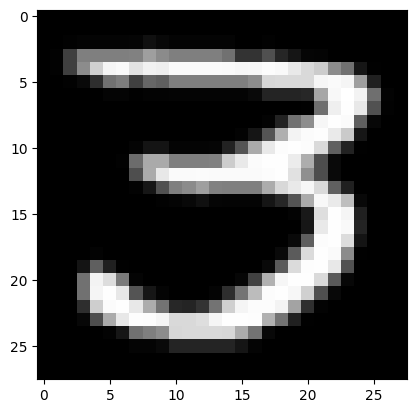

In [8]:
# 이미지 확
plt.imshow(X_train[0], cmap='gray')
print("lable:", y_train[0])

In [9]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## LeNet 베이스라인 모델 정의 ##
tf.random.set_seed(42)
np.random.seed(42)

modelL = keras.models.Sequential([
    keras.layers.Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=[28, 28, 1], padding="same"),
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'),
    keras.layers.Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'),
    keras.layers.AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(120, activation='relu'),
    keras.layers.Dense(84, activation='relu'),
    keras.layers.Dense(47, activation='softmax')
])

modelL.summary()


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_2                  │ (None, 14, 14, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_3                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,851 (253.32 KB)

 Trainable params: 64,851 (253.32 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
%load_ext tensorboard

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

tf.random.set_seed(42)
np.random.seed(42)

num_classes = 47
class LeNet(Sequential):
  def __init__(self, input_shape, nb_classes):
    super().__init__()

    self.add(Conv2D(6, kernel_size=(5,5), strides=(1,1), activation='relu',
                    input_shape=input_shape, padding="same"))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2),padding='valid'))
    self.add(Conv2D(16, kernel_size=(5,5), strides=(1,1), activation='relu',
                    padding='valid'))
    self.add(AveragePooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
    self.add(Flatten())
    self.add(Dense(120, activation='relu'))
    self.add(Dense(84, activation='relu'))
    self.add(Dense(nb_classes, activation='softmax'))

    self.compile(optimizer='adam',
                 loss=categorical_crossentropy,
                 metrics=['accuracy'])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
modelL = LeNet((28,28,1), num_classes)

modelL.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "le_net_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 6)           │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_7                  │ (None, 14, 14, 6)           │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 10, 10, 16)          │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_8                  │ (None, 5, 5, 16)            │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 120)                 │          48,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 47)                  │           3,995 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,851 (253.32 KB)

 Trainable params: 64,851 (253.32 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
modelL.fit(X_train, y_train, epochs=50, steps_per_epoch=32,
           validation_data=(X_valid, y_valid), validation_steps=32, verbose=1)

KeyboardInterrupt: 